January: Part 5 - This notebook is a continuation of gyre_runs_mackenzie03.ipynb. The configuration used to produce these results is still gyre_mackenzie02. 

Recent changes:
* Reorganizing directories and files
* Testing the NEMO Command
* Improved idealized bathymetry (ideal_bathy_03 to ideal_bathy_04 and 05)
* Calculates density using gsw functions to visualize isopycnals
* **Double the resolution**
  * idealized and realistic/Resolution_237_177/Run01 (2.24 km grid cells)
* **More depth layers**
  * idealized and realistic/Resolution_237_177/Run02 (30 instead of 20, lower viscosity)
* **Extended run**
  * idealized and realistic/Resolution_237_177/Run03 (9 days instead of 5 days, uses the yaml file)
* New stratification files for doubled resolution and increased layers

|Run|rn_rdt|nn_itend |nn_write|nn_tau000|jpkdta|rn_ahm_0_lap|ideal_bathy|mpi|
|---|------|---------|--------|---------|------|------------|-----------|---|
|01 |10    |43200(5d)|2160(6h)|8640(1d) |20    |500         |04         |0x0|
|02 |      |         |        |         |30    |125         |05         |   |
|03 |      |77760(9d)|        |         |      |            |           |2x2|

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
# The same bathymetry was used for Run01 and Run02
bathyR_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_02.nc')
bathyR = bathyR_file['Bathymetry']

# Run02 uses an improved bathymetry - wider and more accurate canyon axis depth profile
bathyI1_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_04.nc')
bathyI1 = bathyI1_file['Bathymetry']
bathyI2_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathyI2 = bathyI2_file['Bathymetry']

# The same latitudes are used for Run01 and Run02
coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# The T, U, V results are loaded along with the tmask used for masking.
pathI = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177/'
pathR = '/ocean/imachuca/Canyons/results_mackenzie/realistic/Resolution_237_177/'
cfg = 'Run01'
gridI1, lonI1, latI1, temI1, salI1, sshI1, UI1, VI1, WI1, tmaskI1 = functions_plot.load_model_output(pathI, cfg)
gridR1, lonR1, latR1, temR1, salR1, sshR1, UR1, VR1, WR1, tmaskR1 = functions_plot.load_model_output(pathR, cfg)
depth_levelsI1 = gridI1['deptht'][:]

cfg = 'Run02'
gridI2, lonI2, latI2, temI2, salI2, sshI2, UI2, VI2, WI2, tmaskI2 = functions_plot.load_model_output(pathI, cfg)
gridR2, lonR2, latR2, temR2, salR2, sshR2, UR2, VR2, WR2, tmaskR2 = functions_plot.load_model_output(pathR, cfg)
depth_levelsI2 = gridI2['deptht'][:]

# Calculating density

[Full documentation of gsw functions](http://www.teos-10.org/pubs/gsw/html/gsw_contents.html) and
[Salish Sea tools for calling gsw matlab functions](http://salishsea-meopar-tools.readthedocs.io/en/latest/_modules/salishsea_tools/gsw_calls.html#generic_gsw_caller)

The function **gsw_rho_CT_exact** uses the full Gibbs function, while gsw_rho uses the computationally efficient 75-term expression. It needs Absolute Salinity, Conservative Temperature for in situ density, and a reference pressure for potential density. The function **gsw_p_from_z** calculates sea pressure from height where height is negative in the ocean and from latitude.

In [3]:
def gsw_pressure_arguments(coord_lats, depth_levels, y_transect):
    ''' The main purpose of this function is to reshape
    and tile the (m,) depth array and the (n,) coordinate
    slice so that they can both be (m,n) in order to find
    a (m,n) pressure field.
    '''
    depths = depth_levels.reshape(-1,1)
    depths_neg = depths * -1
    latitudes = coord_lats[y_transect,:]
    
    len_depths = len(depths)
    len_lats = len(latitudes)
    
    z = np.tile(depths_neg, (1, len_lats))
    lat = np.tile(latitudes, (len_depths, 1))
    return z, lat

# ------------------------------------------------------------------------------------------

def gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, salx, temx, tmask):
    ''' This function uses the z and lat calculated in the previous function to calculated
    pressure. This pressure is used alongside salinity and temperature to calculate
    density profiles. Even thought SA and CT are masked arrays (and pressure is not), the
    array for rho is unmasked. tmask is used to mask it, and this follows the same procedure
    as the orginal masking done for SA and CT.
    '''
    z, lat = gsw_pressure_arguments(coord_lats, depth_levels, y_transect)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

    SA = salx[time_ind, :, y_transect, :]
    CT = temx[time_ind, :, y_transect, :]

    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    tmask_rho = tmask[time_ind, : ,y_transect, :]   
    rho_masked = np.ma.array(rho, mask=tmask_rho)
        
    return rho_masked

**Notes on unstaggering w/u:**

    How I visualize unstaggering (simplified):
    ugrid = U[t, :, y, :] = [d, x] = 20 x 237
    wgrid = W[t, :, y, :] = [d, x] = 20 x 237
    
    uavg = ugrid[d, :-1], ugrid[d, 1:] = 20 x 236
    wavg = wgrid[:-1, x], wgrid[1:, x] = 19 x 237
    
    us = uavg[1:, :] = 19 x 236
    ws = wavg[:, 1:] = 19 x 236
    
# Plotting functions

In [4]:
def plot_quiver_stories(U_vel, V_vel, gridT, depth_inds, time_inds, arrow, bathy_file):
    '''This function plots horizontal quiver plots at different depths (columns)
    and different times (rows). It unstaggers the u and v velocities and color
    codes the quivers using the calculated speeds. It also uses viz_tools to 
    mask the bathymetry at that depth.
    '''
    fig, ax = plt.subplots(len(time_inds), len(depth_inds), figsize=(18, 30), sharex=True, sharey=True)
    fig.tight_layout()
    for dep, i in zip(depth_inds, np.arange(len(depth_inds))):
        for time_ind, n in zip(time_inds, np.arange(len(time_inds))):
            ugrid = U_vel[time_ind, dep, :, :]
            vgrid = V_vel[time_ind, dep, :, :]
            u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
            v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
            u_nstg = u_nstg0[::arrow,::arrow]
            v_nstg = v_nstg0[::arrow,::arrow]
            x_slice = np.arange(1, ugrid.shape[1])[::arrow]
            y_slice = np.arange(1, ugrid.shape[0])[::arrow]
            speeds = np.sqrt(u_nstg**2 + v_nstg**2)

            q = ax[n, i].quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,0.3],
                          pivot='tip', cmap='Spectral_r', width=0.005, headwidth=2.5)
            ax[n, i].set_ylim(0, y_slice[-1])
            ax[n, i].set_xlim(0, x_slice[-1])
            timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
            ax[n,i].set_yticklabels([])
            dep_m = round(gridT['deptht'][:][dep],2)
            if i == 0:
                ax[n, i].set_ylabel(timestamp, fontsize=16)
                fig.colorbar(q, ax=ax[n, i])
            if n == 0:
                ax[n,i].set_title('depth : '+str(dep_m)+' m', fontsize=16)
            #ax[n,i].contour(bathy, levels = [dep_m], colors='k', linewidths=2, alpha=0.5)
            viz_tools.plot_land_mask(ax[n,i],bathy_file,'grid', dep_m, None, None, 'wheat')
    return fig

def plot_canyons_transects(bathyR, bathyI, y_transects):
    '''This function plots the ideal and real bathymetries and
    adds lines along the canyon axis and for a y transect.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    levels = np.linspace(40, 1300, 10)
    c1 = ax1.contour(bathyR[:], levels = levels, colors='k', linewidths=2, alpha=0.5)
    c2 = ax2.contour(bathyI[:], levels = levels, colors='k', linewidths=2, alpha=0.5)
    ax1.clabel(c1, inline=1, fontsize=10); ax2.clabel(c2, inline=1, fontsize=10)
    ax1.axvline(143); ax2.axvline(118)  
    yR = y_transects[0]; yI = y_transects[1]
    ax1.axhline(yR); ax2.axhline(yI) 
    return fig

def plot_depth_profiles(varbsR, varbsI):
    '''The purpose of these plots is to monitor the influence of northern boundary
    on the circulation closer to the canyon. It plots 4 pairs of ideal and real results:
    salinity, temperature, u, and v. 
    '''
    fig, [(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)] = plt.subplots(2,4,figsize=(20, 8), sharey=True,sharex=True)
    fig.tight_layout()
    axesR = [ax1, ax3, ax5, ax7]; axesI = [ax2, ax4, ax6, ax8]
    for axes, varbs, title, x in zip([axesR, axesI], [varbsR, varbsI], ['Real ',' Ideal '], [143, 118]):
        ttls = ['salinity', 'temperature', 'U', 'V']
        cmaps = [cmo.cm.tempo, cm.Spectral_r, cmo.cm.balance, cmo.cm.balance]
        for ax, var, cmap, ttl in zip(axes, varbs, cmaps, ttls):
            cmap.set_bad('wheat')
            this_var = var[18, :, :, x]
            if ttl == 'U' or ttl == 'V':
                cmin = this_var.min()
                c = ax.pcolormesh(this_var, cmap=cmap, vmin = cmin, vmax = -1*cmin)
            else:
                c = ax.pcolormesh(this_var, cmap=cmap)
            ax.set_ylim([20,0])
            ax.set_title(title+ttl)
            fig.colorbar(c, ax=ax)
    return fig

def plot_isopycnal_stories(gridTs, sals, tems, tmasks, xlims, y_transects, time_inds, coord_lats, depth_levels):
    '''This function plots vertical density profiles at different times (rows) for
    the idealized and realistic canyons (columns). It takes in the y index that 
    outlines the vertical slice. It also takes in the latitudes and depth necessary
    to calculate the pressure calculated inside the density function.
    '''
    x_inds = np.arange(sals[0].shape[-1])
    fig, ax = plt.subplots(len(time_inds), len(sals), figsize=(18, len(time_inds)*5))
    cmap = cm.Spectral
    levels = np.linspace(1026, 1029, 7)
    for gridT, sal, tem, tmask, xlim, y_transect, n in zip(gridTs, sals, tems, tmasks, xlims, y_transects, 
                                                           np.arange(len(sals))):
        for time_ind, i in zip(time_inds, np.arange(len(time_inds))):
            rho = gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, sal, tem, tmask)
            p = ax[i,n].pcolormesh(x_inds, depth_levels, rho, cmap = cmap, vmin = 1020, vmax = 1030)
            c = ax[i,n].contour(x_inds, depth_levels, rho, levels = levels, colors='k', linewidths=1.5)
            ax[i,n].set_ylim([550,0])
            ax[i,n].set_xlim(xlim)
            timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
            ax[i,n].set_title(timestamp)
            fig.colorbar(p, ax=ax[i,n])
            ax[i,n].set_axis_bgcolor('wheat')
    return fig

In [5]:
np.linspace(1026, 1029, 7)

array([ 1026. ,  1026.5,  1027. ,  1027.5,  1028. ,  1028.5,  1029. ])

# Double Resolution - 20 Depth Levels 

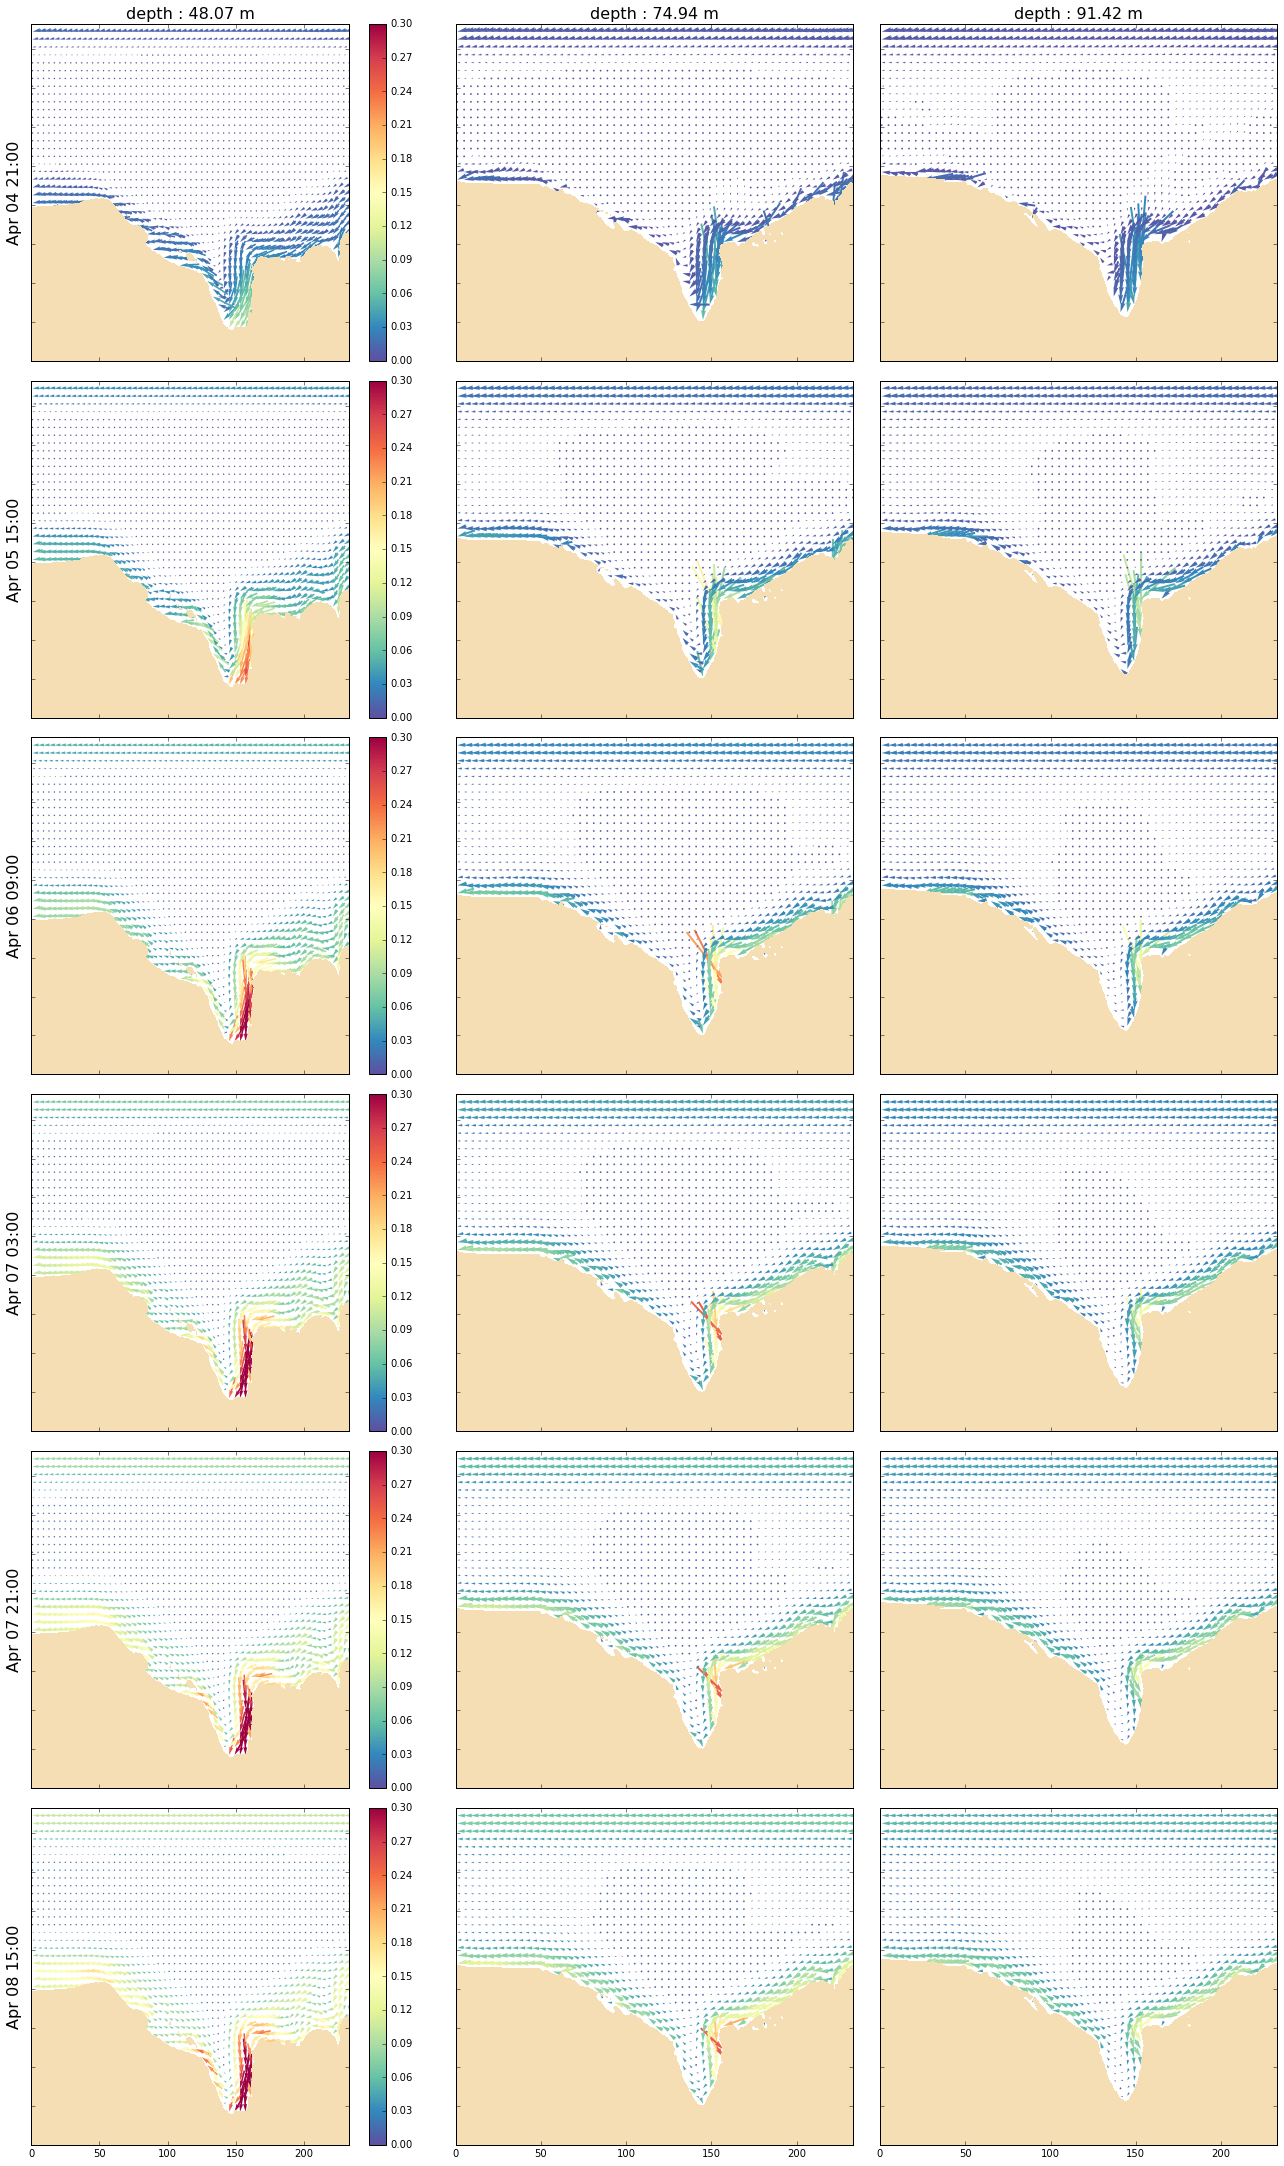

In [6]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UR1, VR1, gridR1, depth_inds, time_inds, 4, bathyR_file)

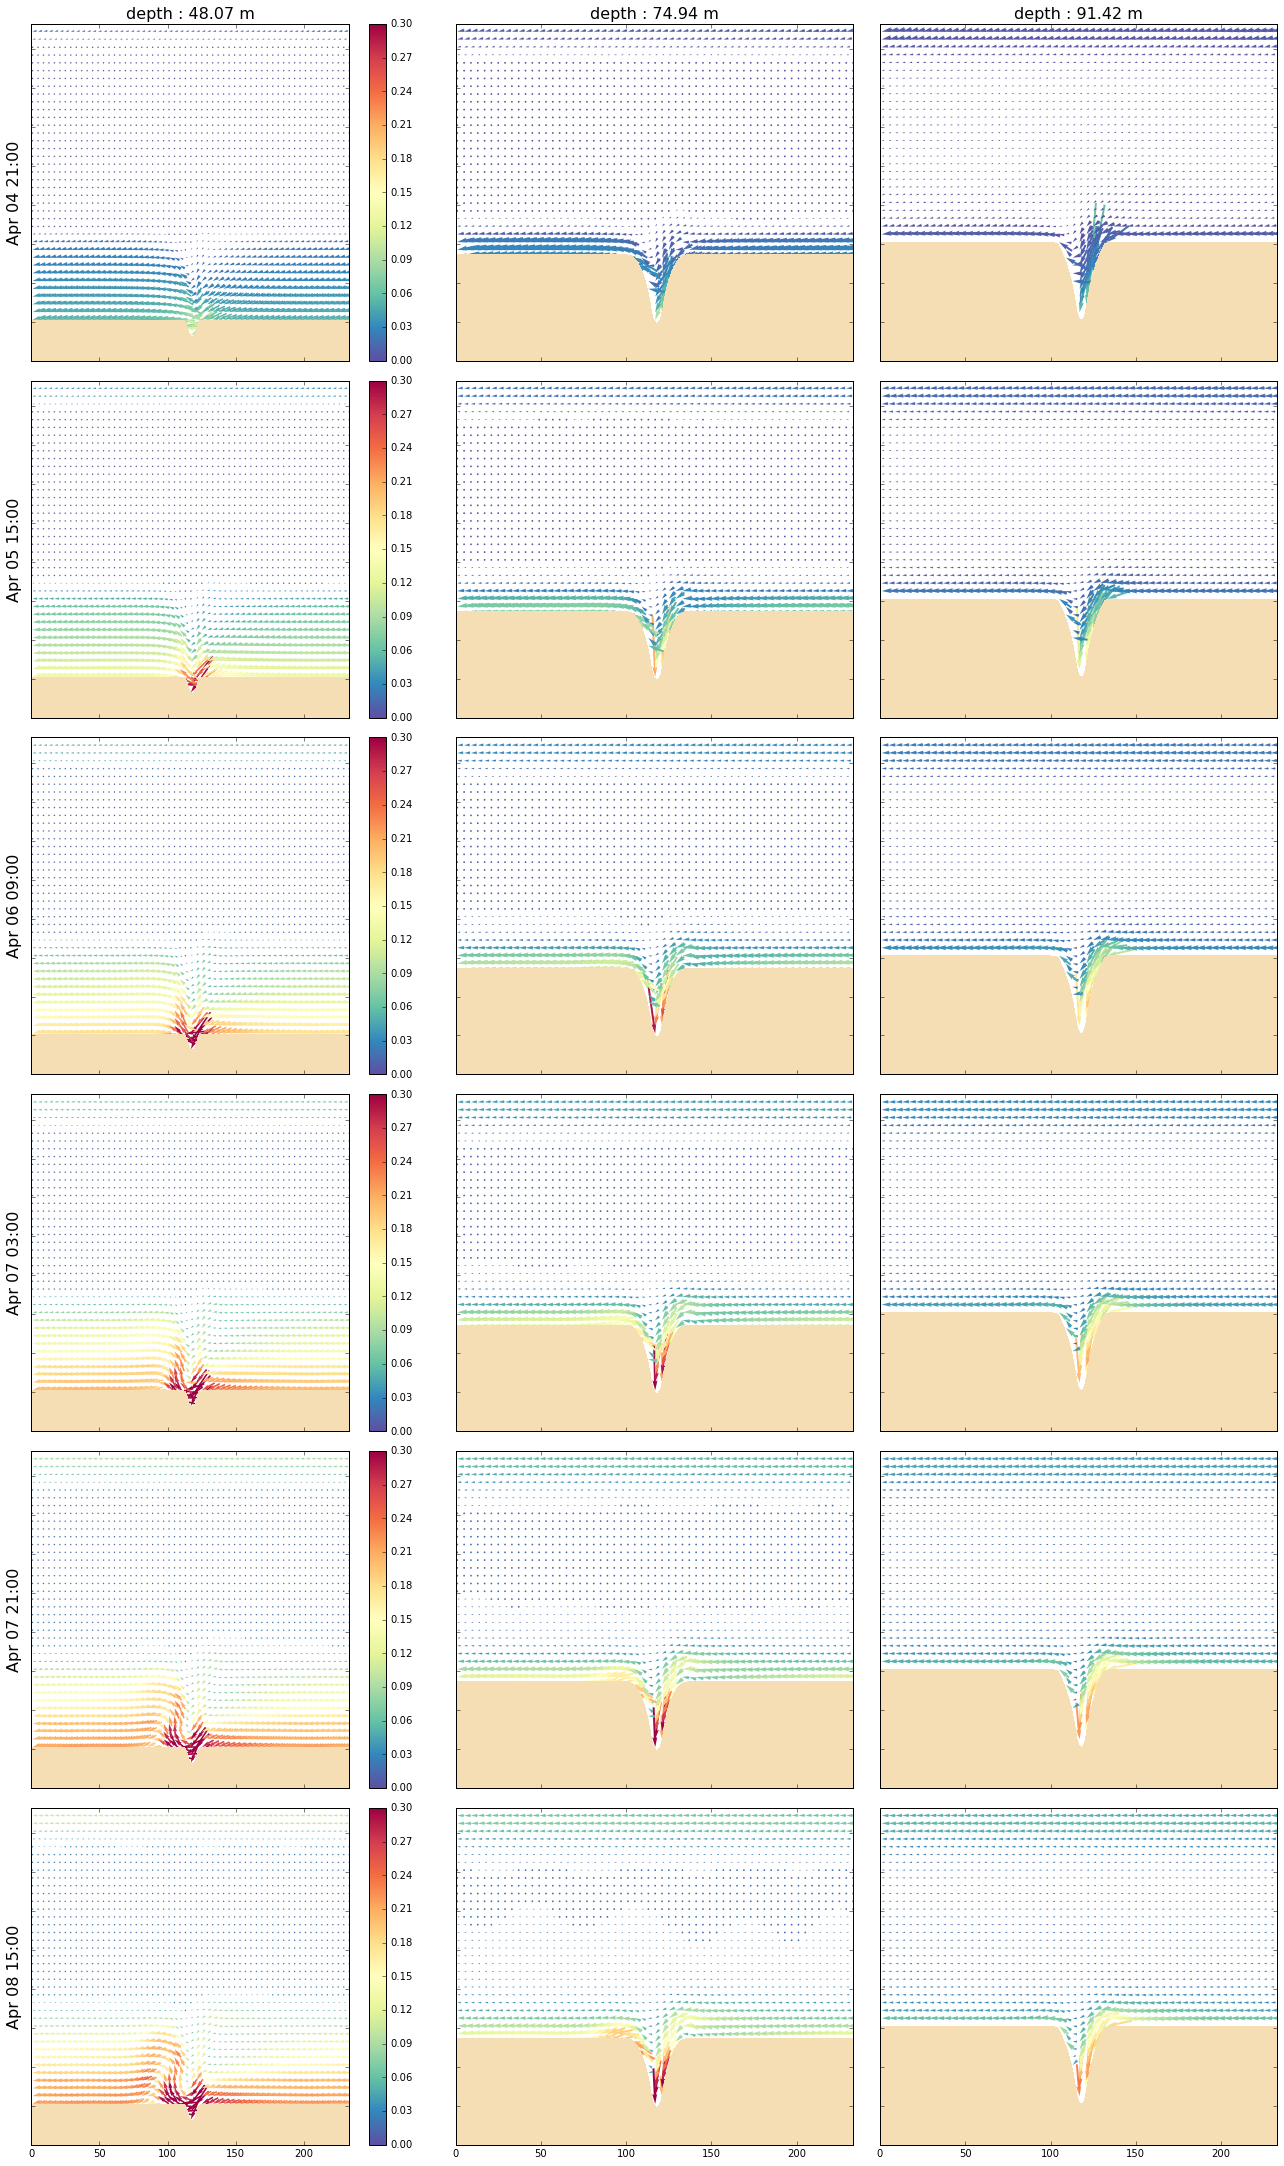

In [7]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UI1, VI1, gridI1, depth_inds, time_inds, 4, bathyI1_file)

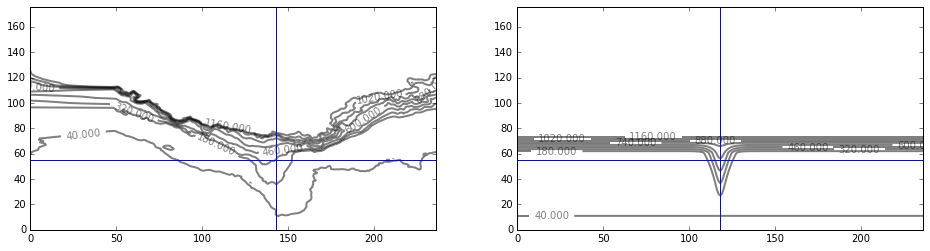

In [8]:
fig = plot_canyons_transects(bathyR, bathyI1, [55, 55])

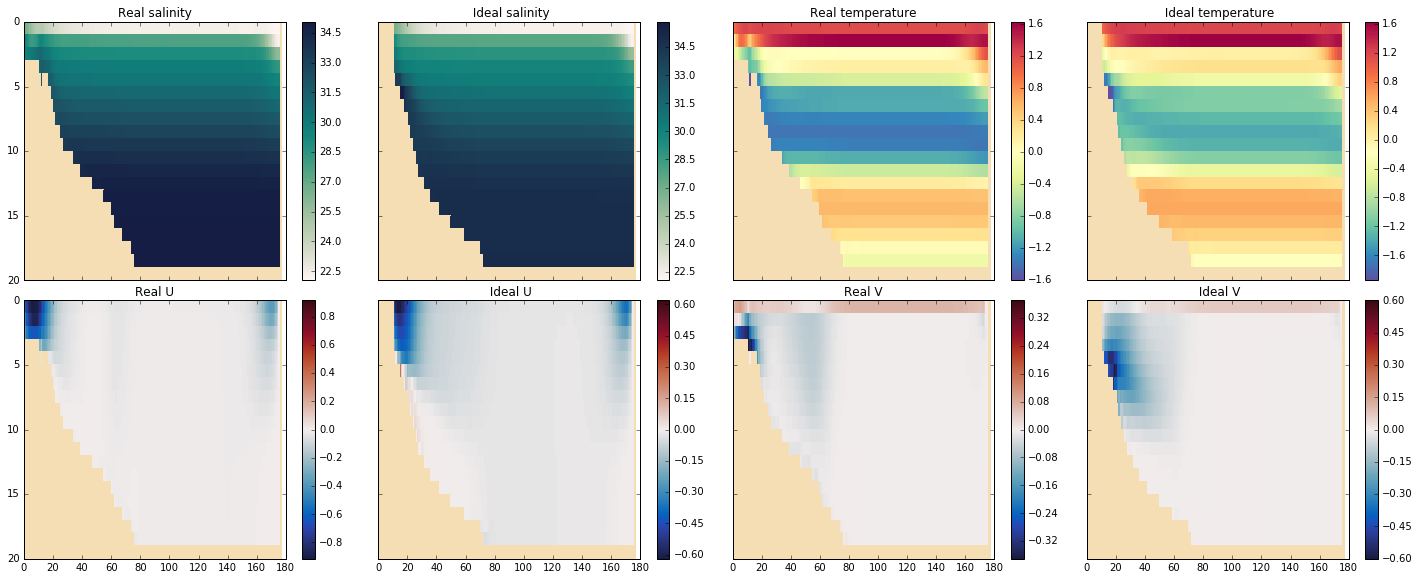

In [9]:
varbsR = [salR1, temR1, UR1, VR1]
varbsI = [salI1, temI1, UI1, VI1]
fig = plot_depth_profiles(varbsR, varbsI)

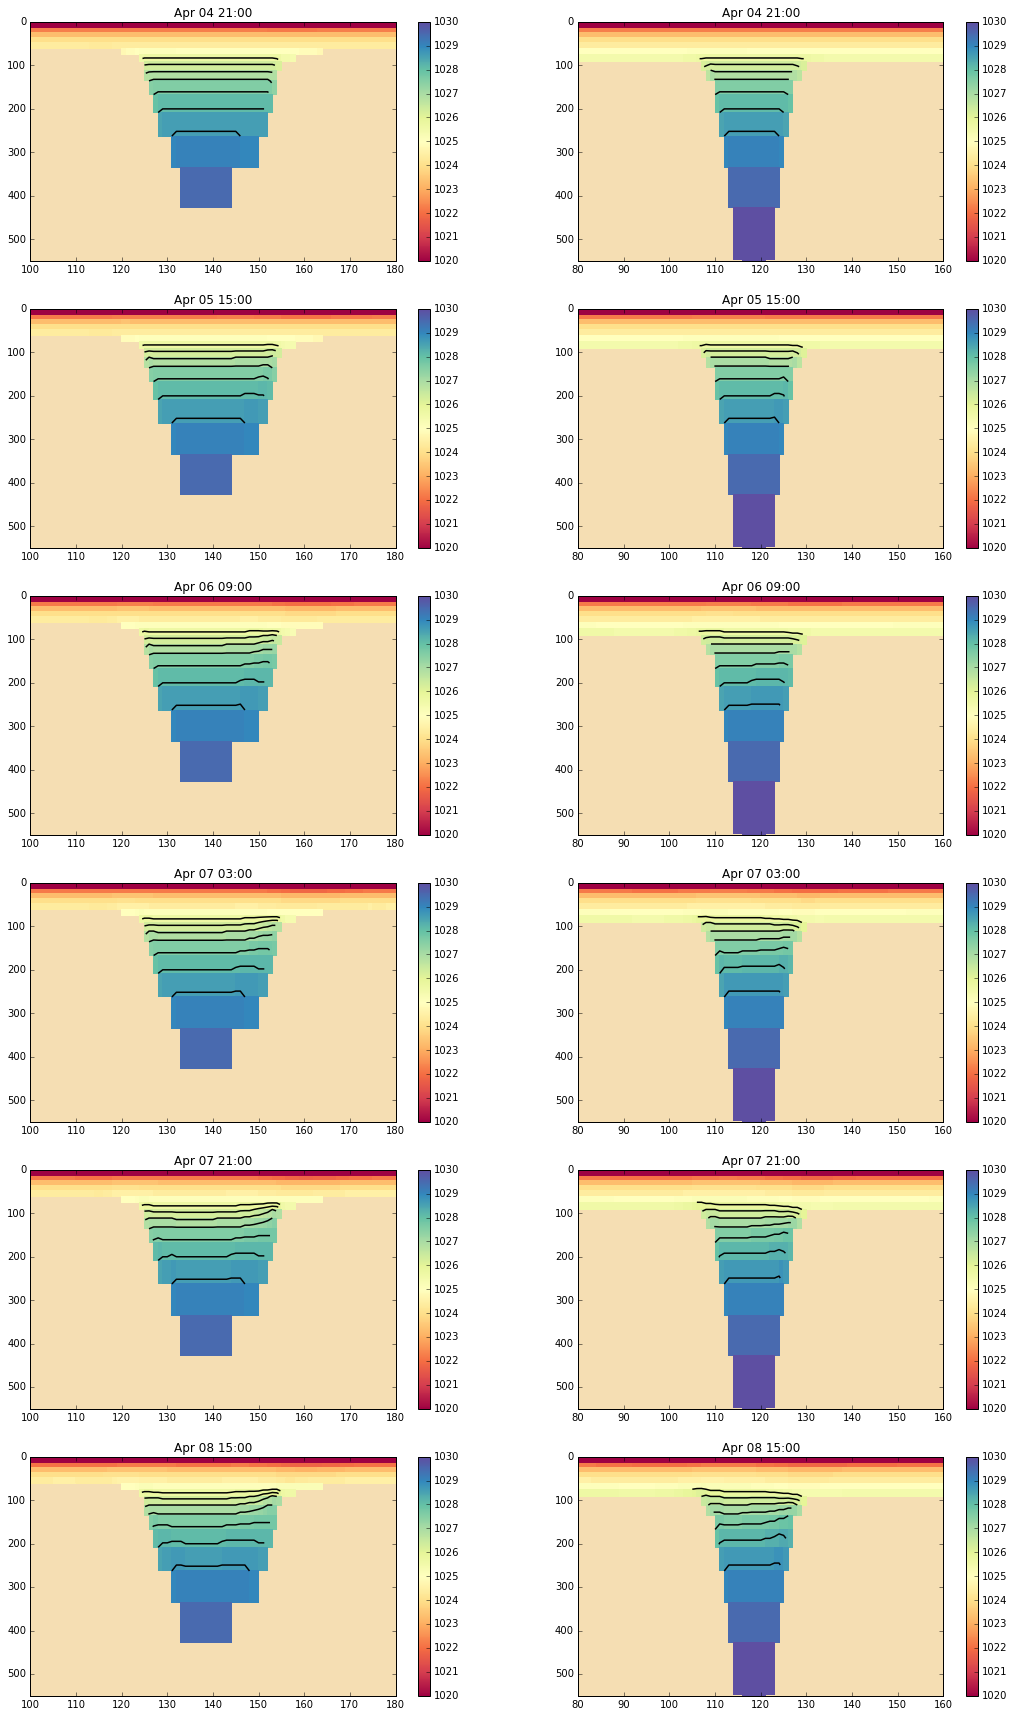

In [10]:
gridTs = [gridR1, gridI1]
sals = [salR1, salI1]
tems = [temR1, temI1]
tmasks = [tmaskR1, tmaskI1]
y_transects = [55, 55]
time_inds = [3, 6, 9, 12, 15, 18]
xlims = [[100,180], [80,160]]
depth_levels = depth_levelsI1

fig = plot_isopycnal_stories(gridTs, sals, tems, tmasks, xlims, y_transects, time_inds, coord_lats, depth_levels)

# Double Resolution - 30 Depth Levels 

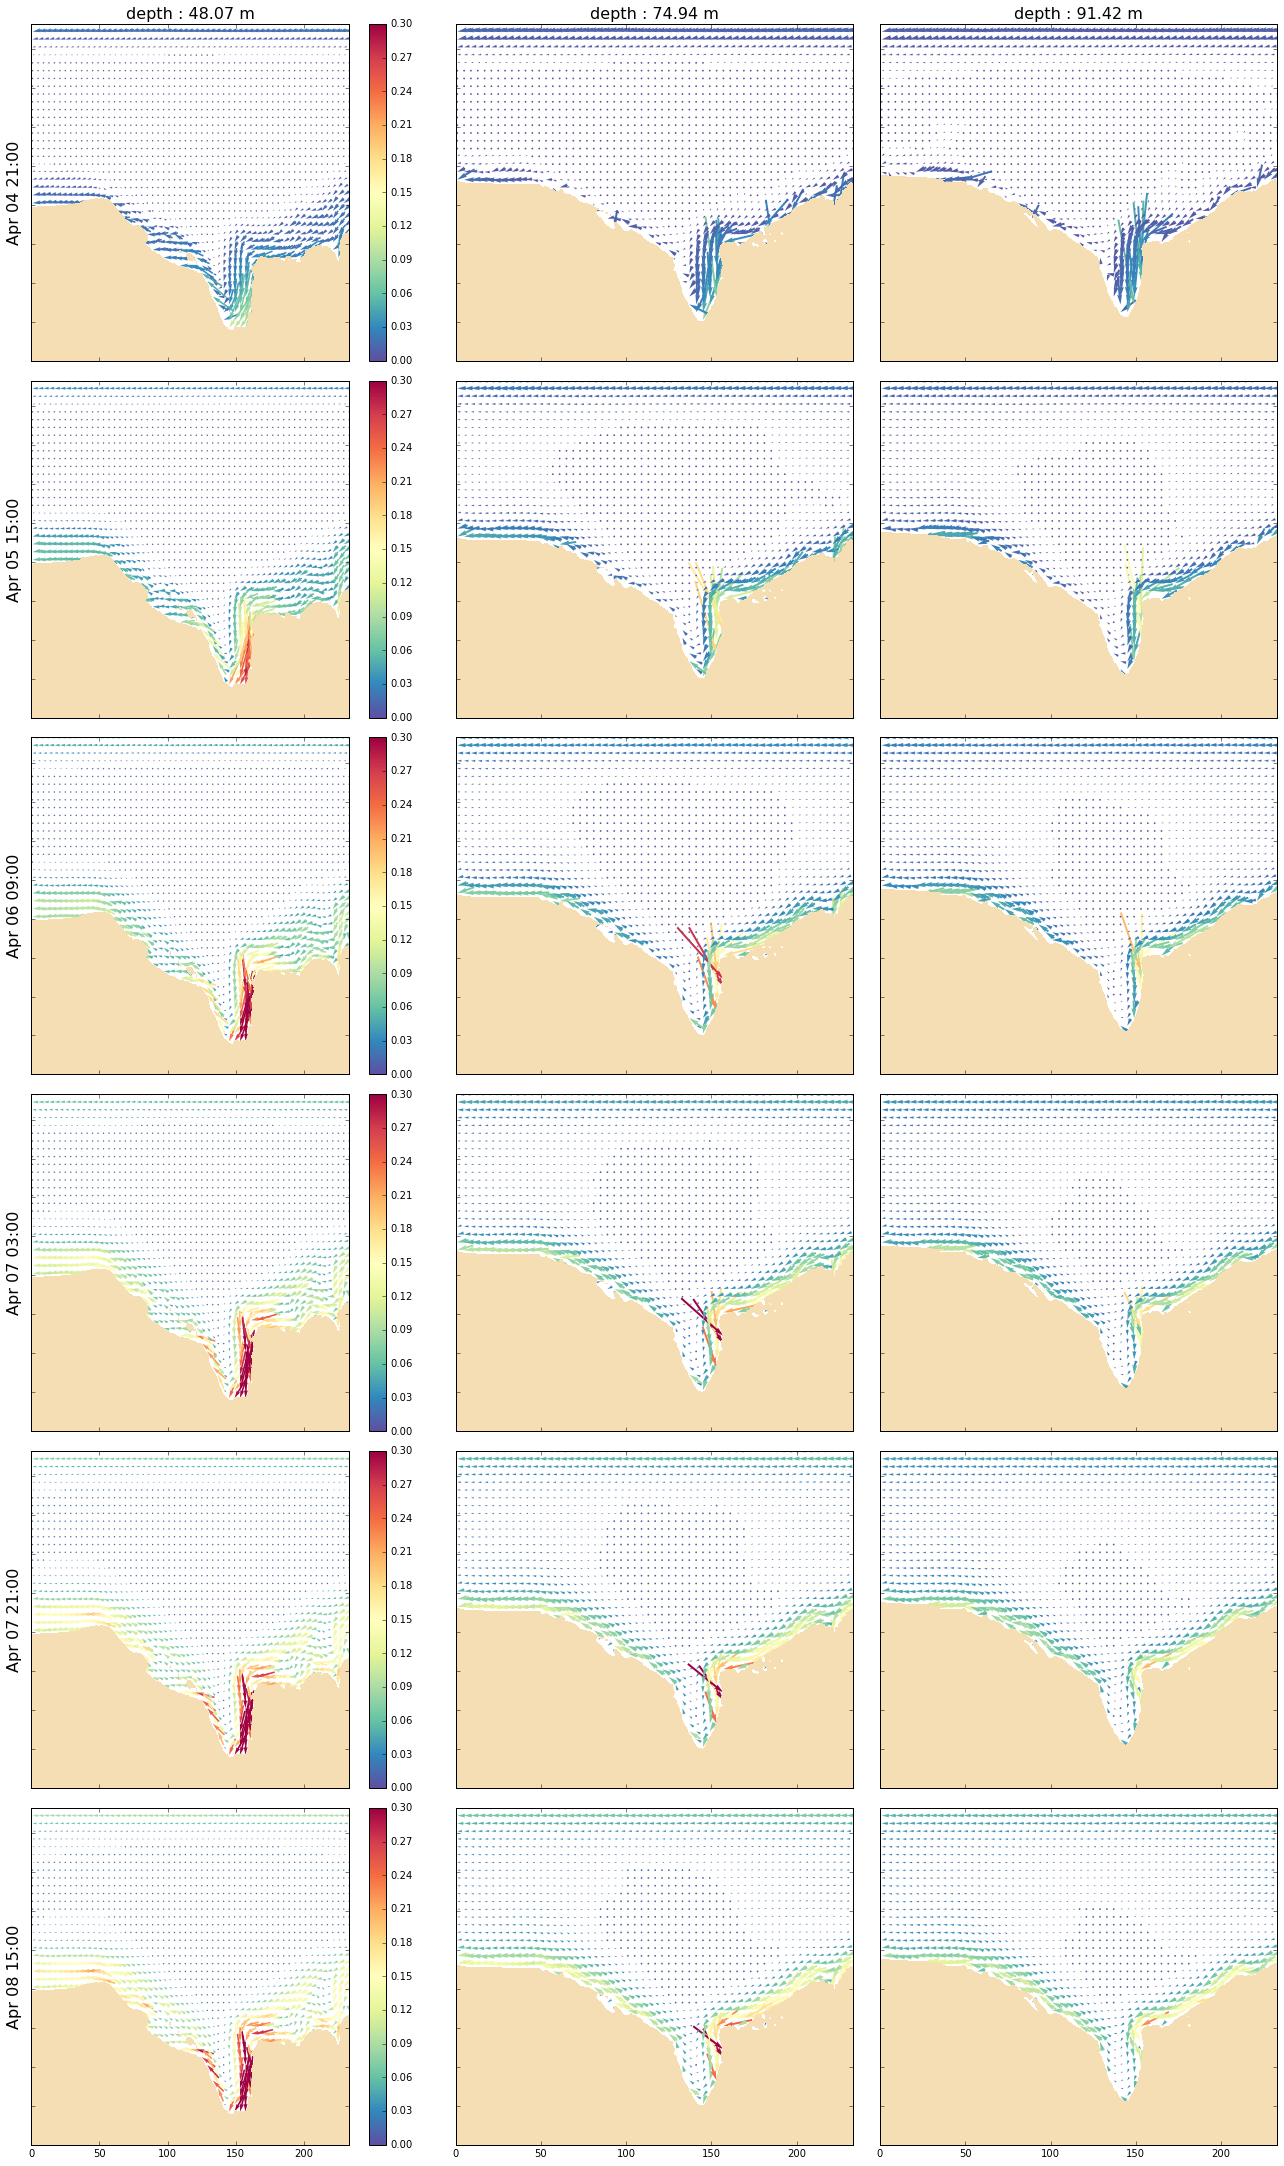

In [11]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UR2, VR2, gridR2, depth_inds, time_inds, 4, bathyR_file)

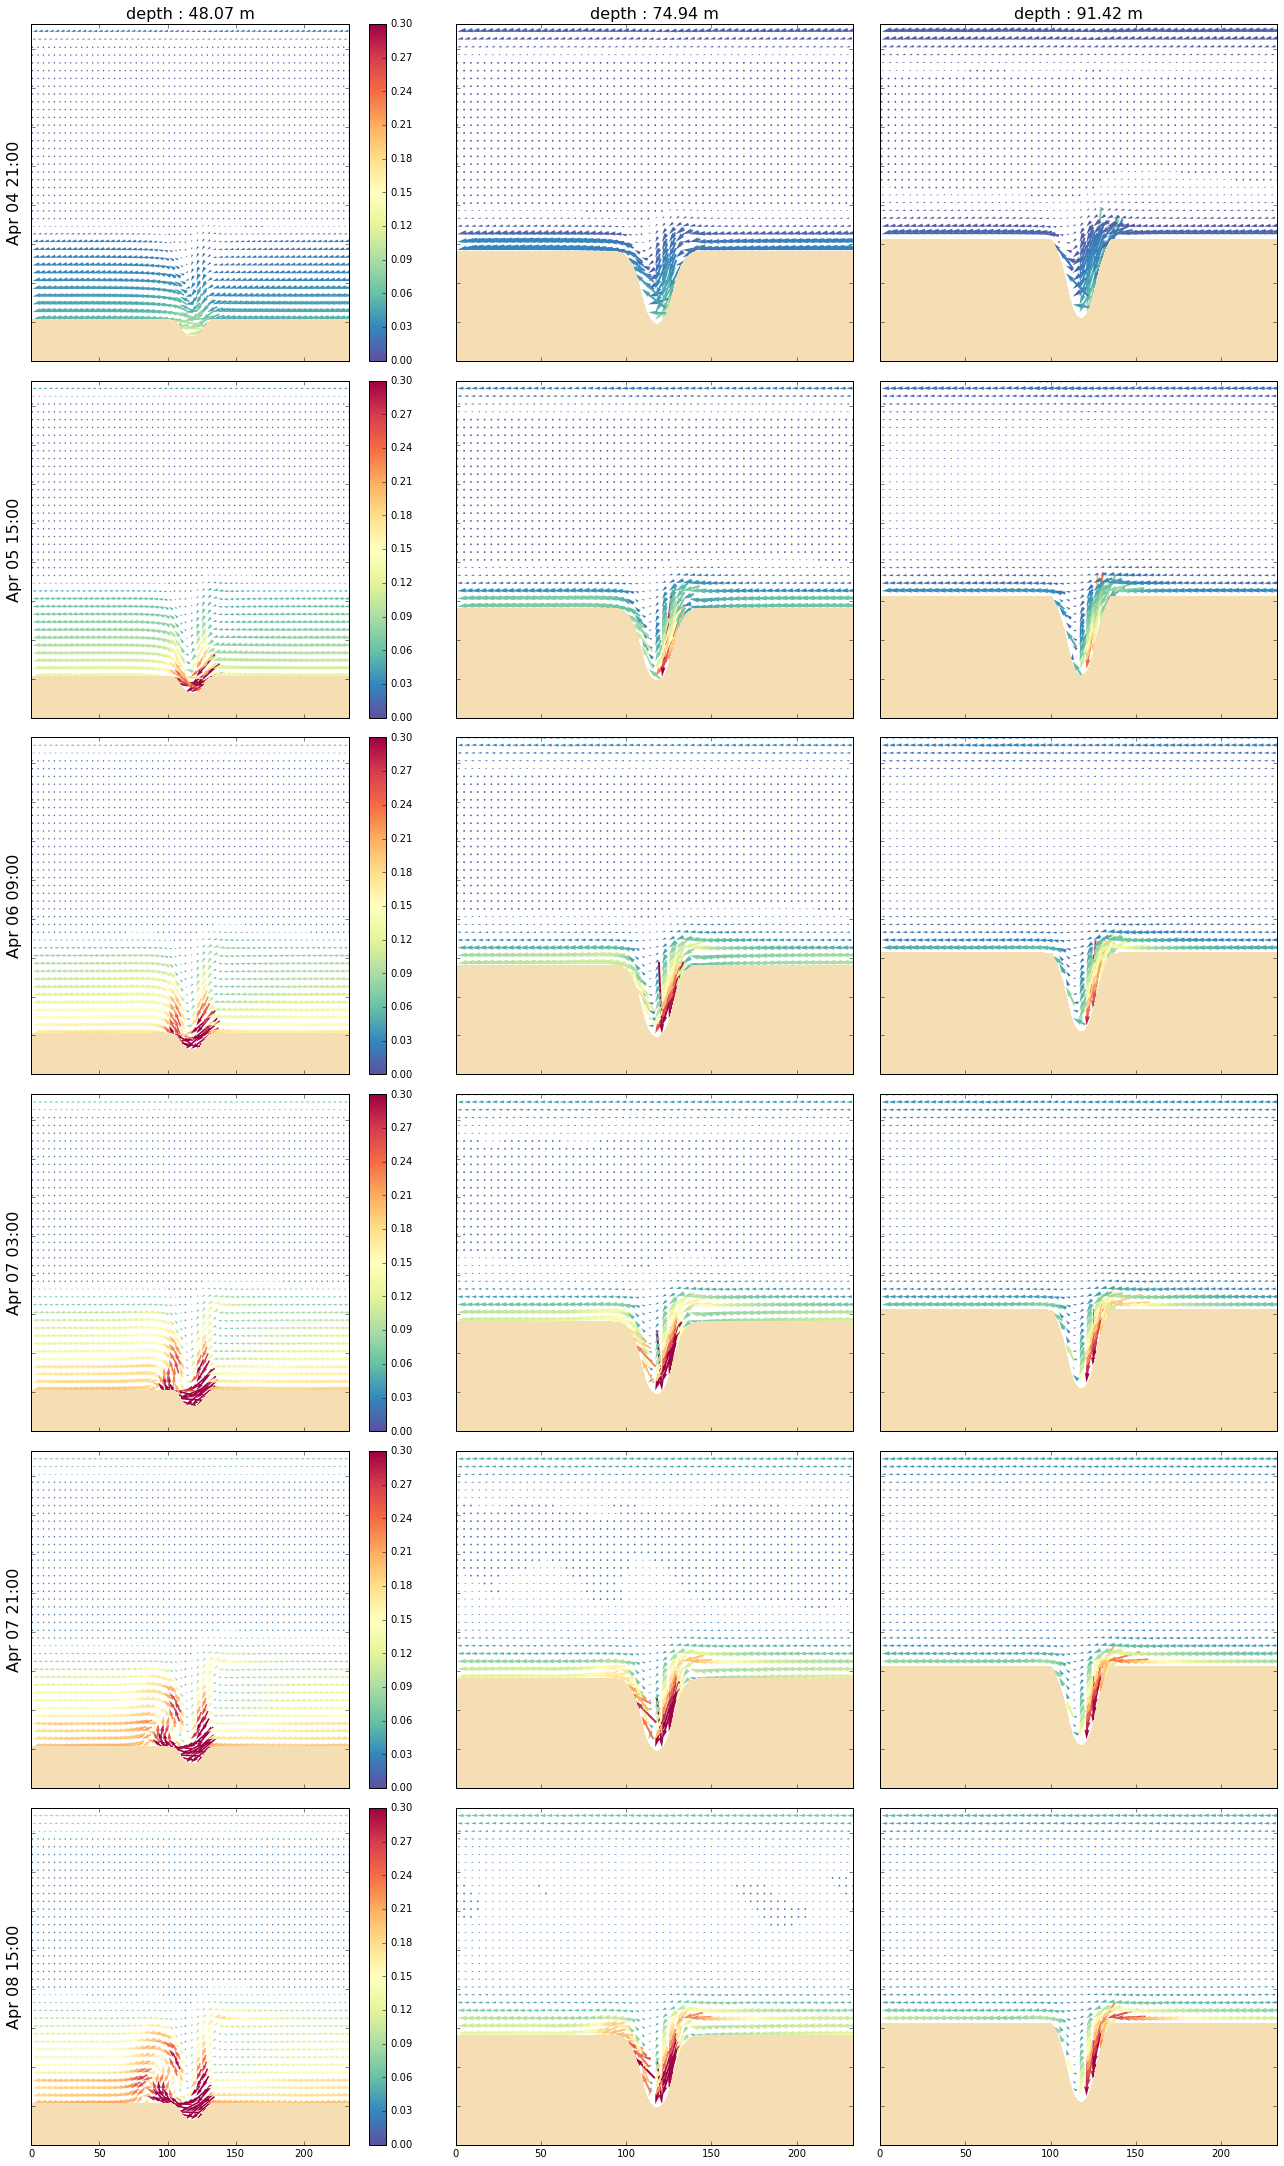

In [12]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UI2, VI2, gridI2, depth_inds, time_inds, 4, bathyI2_file)

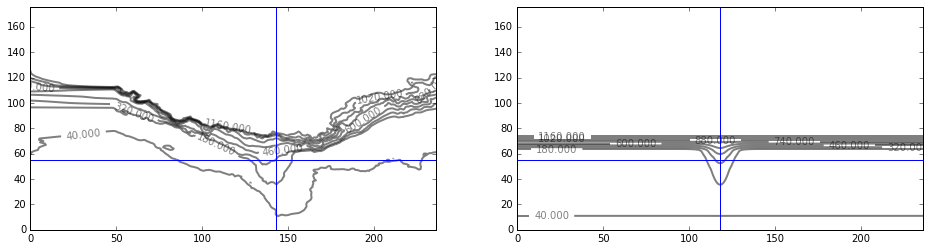

In [13]:
fig = plot_canyons_transects(bathyR, bathyI2, [55, 55])

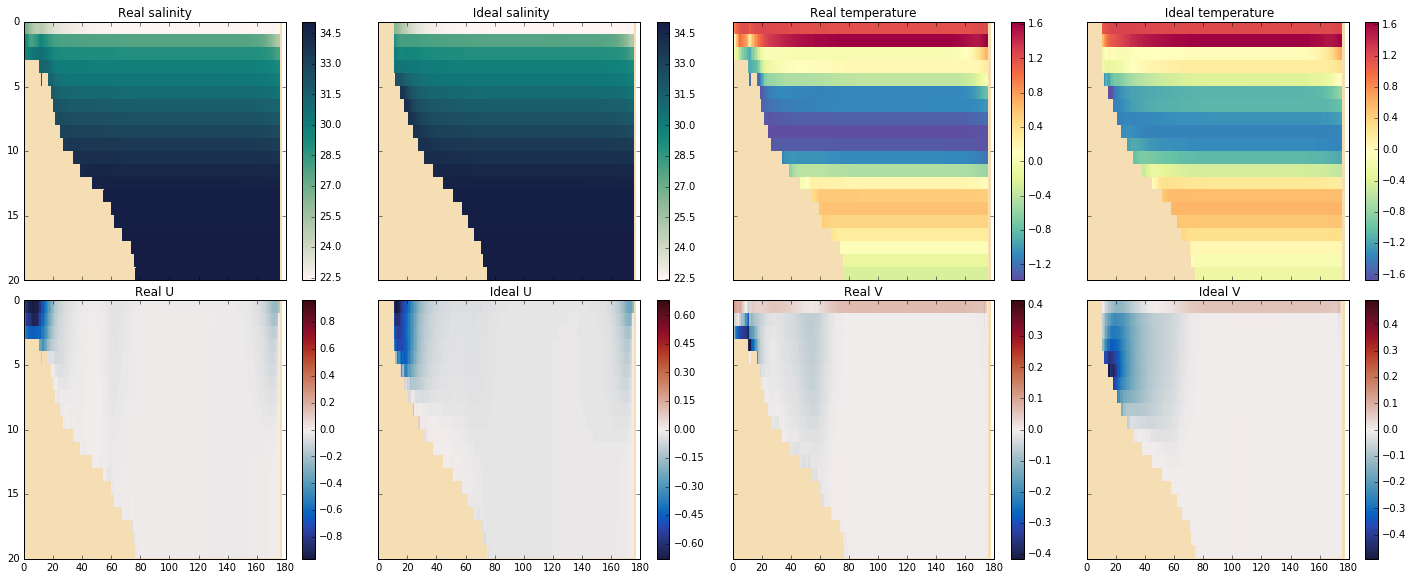

In [14]:
varbsR = [salR2, temR2, UR2, VR2]
varbsI = [salI2, temI2, UI2, VI2]
fig = plot_depth_profiles(varbsR, varbsI)

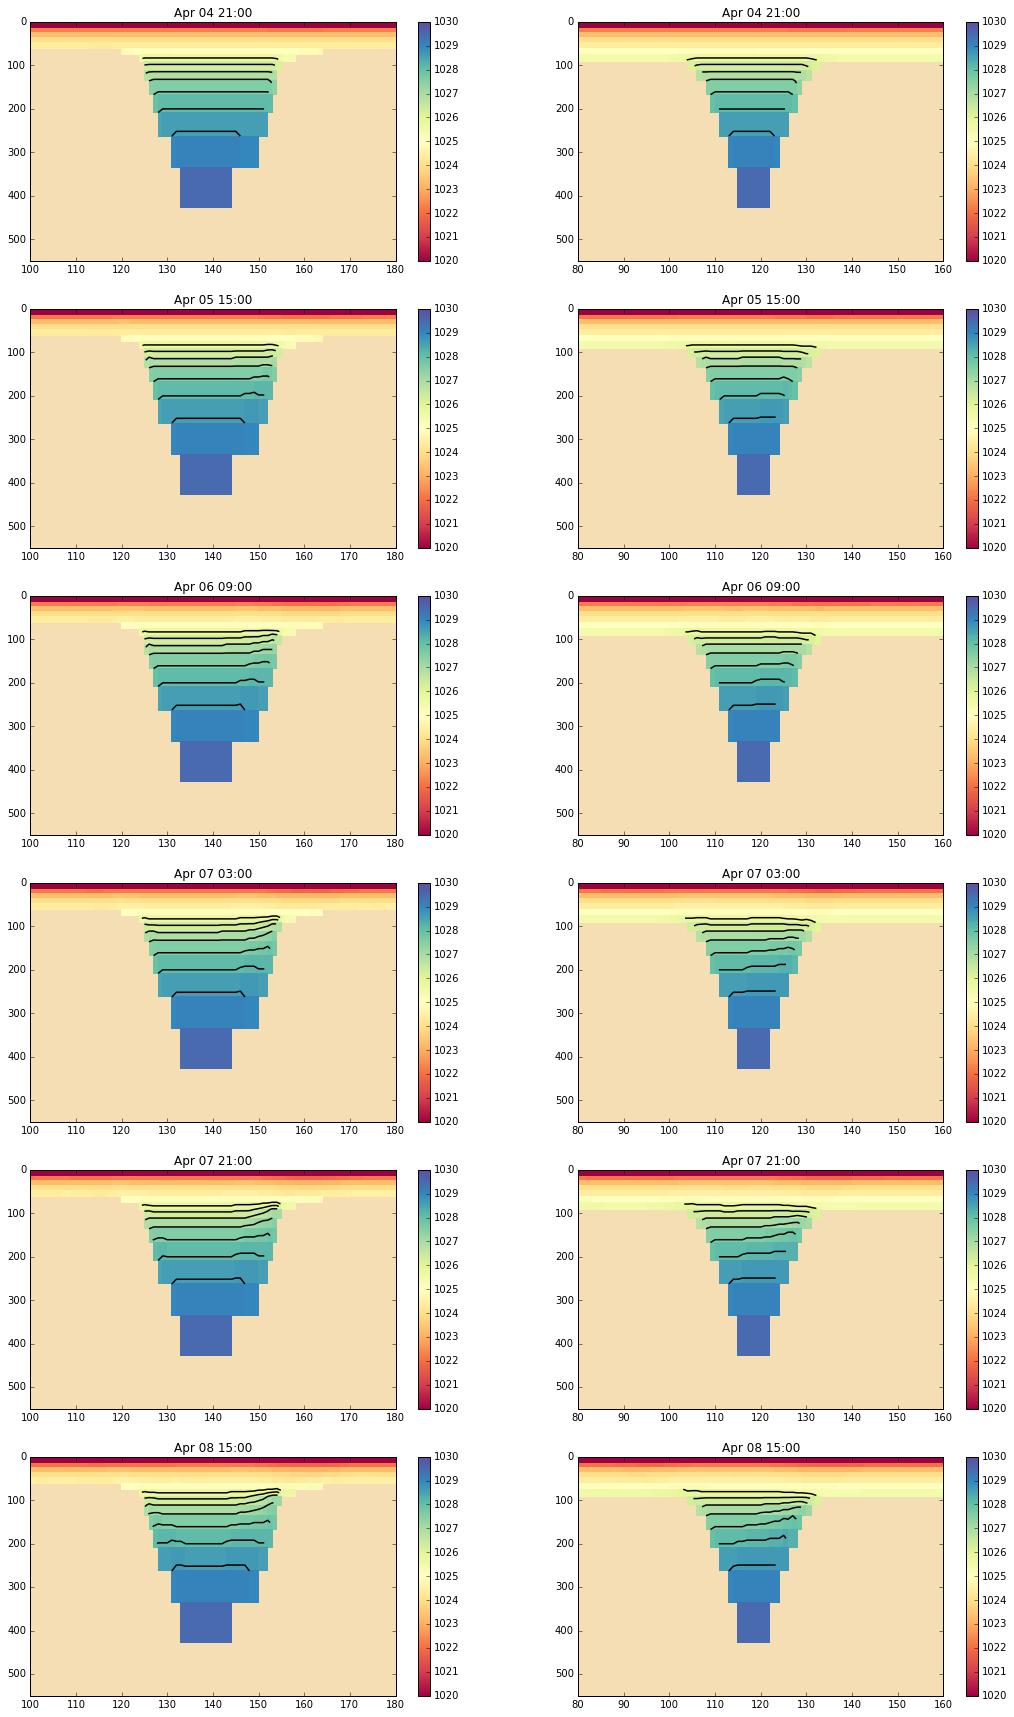

In [15]:
gridTs = [gridR2, gridI2]
sals = [salR2, salI2]
tems = [temR2, temI2]
tmasks = [tmaskR2, tmaskI2]
y_transects = [55, 55]
time_inds = [3, 6, 9, 12, 15, 18]
xlims = [[100,180], [80,160]]
depth_levels = depth_levelsI2

fig = plot_isopycnal_stories(gridTs, sals, tems, tmasks, xlims, y_transects, time_inds, coord_lats, depth_levels)

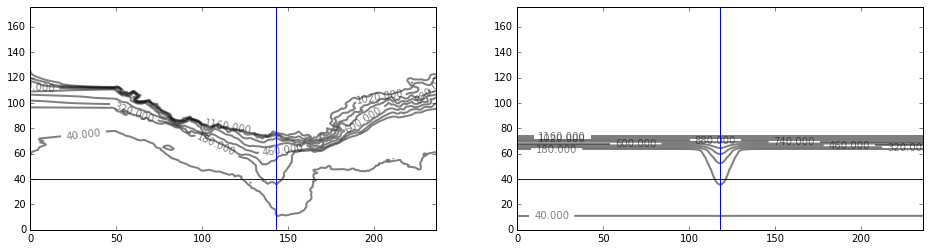

In [16]:
fig = plot_canyons_transects(bathyR, bathyI2, [40, 40])

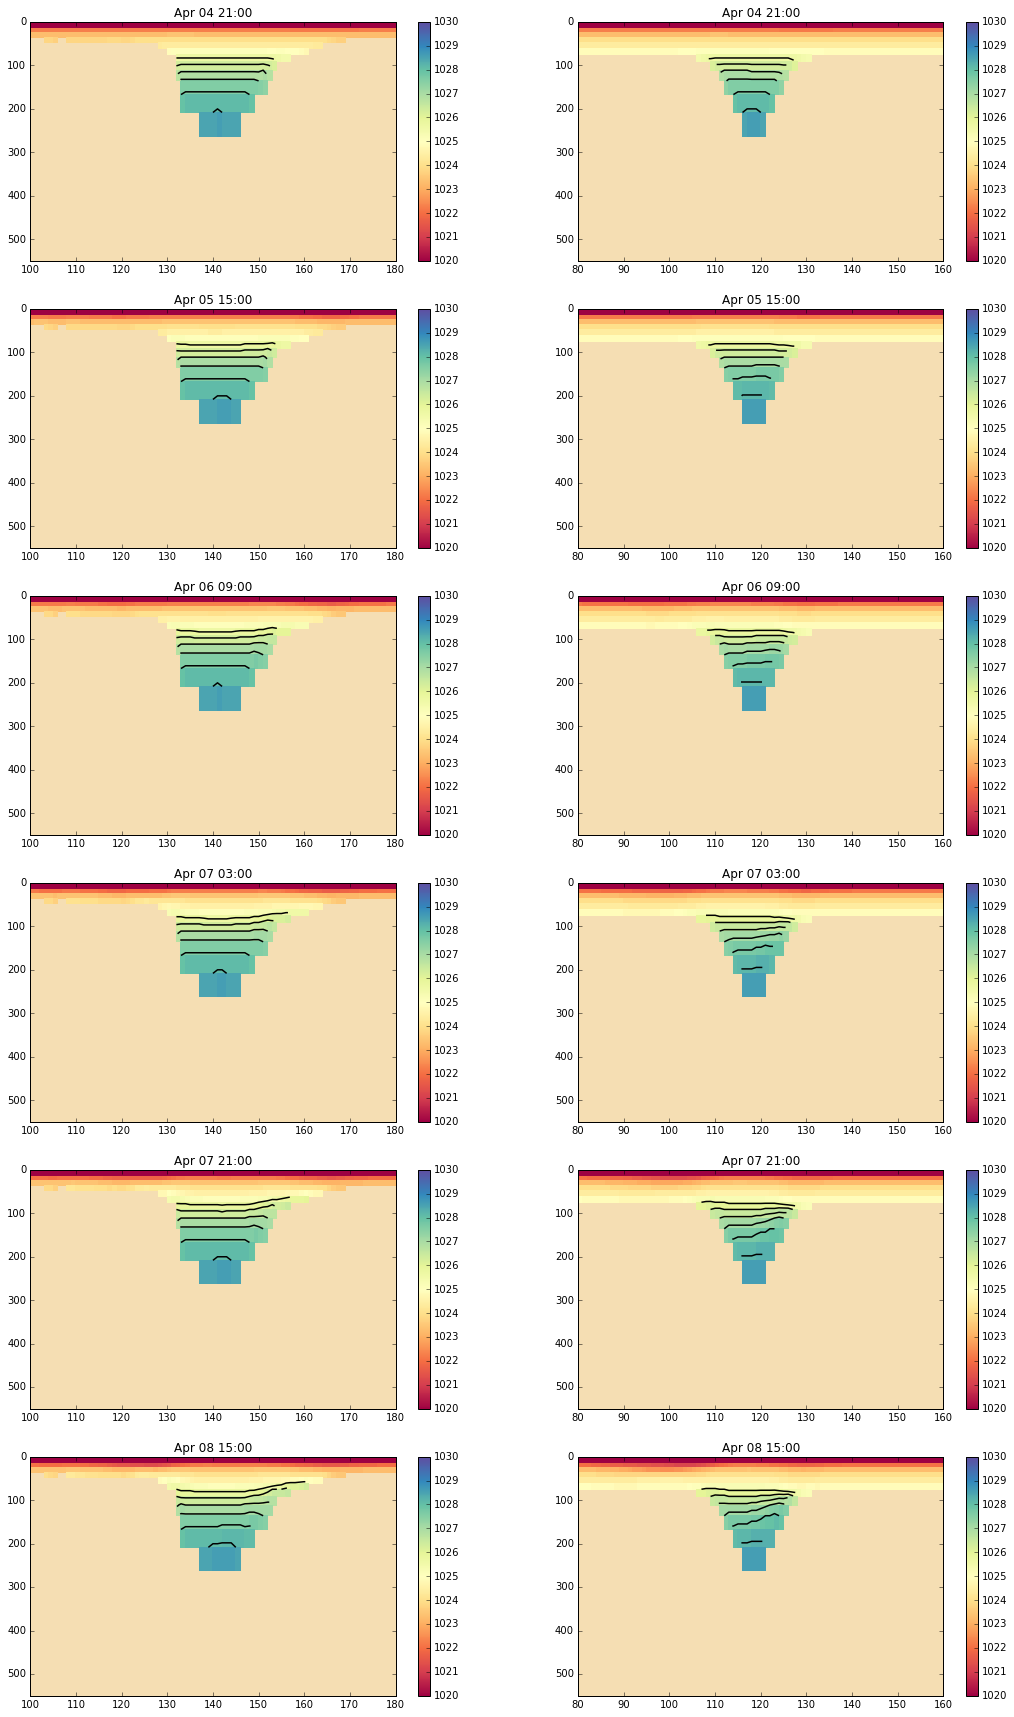

In [17]:
gridTs = [gridR2, gridI2]
sals = [salR2, salI2]
tems = [temR2, temI2]
tmasks = [tmaskR2, tmaskI2]
y_transects = [40, 40]
time_inds = [3, 6, 9, 12, 15, 18]
xlims = [[100,180], [80,160]]
depth_levels = depth_levelsI2

fig = plot_isopycnal_stories(gridTs, sals, tems, tmasks, xlims, y_transects, time_inds, coord_lats, depth_levels)